In [1]:
# We perform a priliminary feature selection using sci-kit learn
# Importing required libraries
from collections import defaultdict
import numpy as np
from scipy import stats
from distfit import distfit
from tqdm import tqdm
from tqdm import trange
from tqdm.gui import tqdm as tqdm_gui
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.feature_selection import RFE, RFECV, VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer, RobustScaler,QuantileTransformer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Pre-processing functions
# Function to perform priliminary checks and data manipulation, return slightly altered DataFrame
def Data_Check_1(df):

    # Dropping target column
    df = df.drop('responded',axis=1)

    # Dropping ID column duie to extreme cardinality
    df = df.drop(columns = 'id')
    
    # Checking duplicates
    print(f'Duplicate check, {df.duplicated().sum()} found!')

    # Checking for null values
    print(f'Null check. {(len(df.columns[list(df.isnull().sum()>0)]))} columns with nulls found!')
    null_features = df.columns[list(df.isnull().sum()>0)]

    if len(null_features)>0:
        avg = 0
        for col in null_features:
            avg += df[col].isnull().sum() * 100 / len(df[col])
        print(f'Average null percentage {avg/len(null_features)} in the columns below')
        print(null_features)

    # Drop Na
    df = df.dropna(axis=1)
    
    print('checks complete')
    
    return df

# Function to check feature distribution , returns summary of feature distributions stats
def Data_check_2(df):
    
    # Priliminary data transformation for distribution checks
    # pipe to scale number and accomodate outliers
    Number_transformer = Pipeline(steps=[
        ('Scaler', RobustScaler())])
    # pipe to encode and scale objects/text
    Text_transformer = Pipeline(steps=[
        ('Encorder', OrdinalEncoder()),
        ('Scaler', RobustScaler())])
    # transformer to apply column wise pipes
    preprocessor = ColumnTransformer(
        transformers=[
            ('Numbers', Number_transformer, selector(dtype_include =('int64','float64'))),
            ('Text', Text_transformer, selector(dtype_include='object'))])
    # final pipe to transform data 
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor)])

    # Creating return dataframe
    X = pd.DataFrame(clf.fit_transform(df.loc[:, df.columns != 'responded']),columns=clf.get_feature_names_out())

    # Using distfit to determin features distributions
    Summary=[]
    for column in X:
        dist = distfit()
        dist.fit_transform(X[column])
        Summary.append([column,dist.summary])
    # Code takes a while to run but features were confirmed to be non-gaussian
    # This removes the possiblity of p-value based feature selections even after transformations

    return Summary


# Function to perform low level feature elimination, returns list of features to use for further selection
def Feature_Elimination_1(df):
    
    # Priliminary data transformation for distribution checks
    # pipe to scale number and accomodate outliers
    Number_transformer = Pipeline(steps=[
        ('Scaler', RobustScaler())])
    # pipe to encode and scale objects/text
    Text_transformer = Pipeline(steps=[
        ('Encorder', OrdinalEncoder()),
        ('Scaler', RobustScaler())])
    # transformer to apply column wise pipes
    preprocessor = ColumnTransformer(
        transformers=[
            ('Numbers', Number_transformer, selector(dtype_include =('int64','float64'))),
            ('Text', Text_transformer, selector(dtype_include='object'))])
    # final pipe to transform data 
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('V0',VarianceThreshold(threshold=0)),
        ('V1',VarianceThreshold(threshold=0.01))])

    # Creating return dataframe
    print('Fitting data through the pipe')
    X = pd.DataFrame(clf.fit_transform(df.loc[:, df.columns != 'responded']),columns=clf.get_feature_names_out())

    # Removing highly correleated features
    print('Removing highly correlated features')
    corr_mat = X.corr()
    iters = range(len(corr_mat.columns) - 1)
    drop_cols = []
    for i in iters:
        for j in range(i+1):
            item = corr_mat.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            # If correlation exceeds the threshold
            if val >= 0.8:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])
    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    X = X.drop(columns=drops)
    print(f'Removed {len(drop_cols)} Columns')

    # # Removing extremely low and high varience features
    print('Removing extremely variant features')
    check = X.var()>3
    cnames = X.columns
    cnames[check]
    X = X.drop(cnames[check],axis=1)

    # Threshold values decided after 
    check = X.var()<0.2
    cnames = X.columns
    cnames[check]
    X = X.drop(cnames[check],axis=1)

    Features = list(X.columns.values)
    Features = [name.replace('Numbers__','') for name in Features]
    Features = [name.replace('Text__','') for name in Features]
    
    return Features

In [3]:
# Functions for feature selection and cross validation
# Function to apply scaler and transformer to data
def Feature_Transform(X):
    # # Check if input/output size matches
    # if (X.shape[0] != Y.shape[0]):
    #     raise Exception(f"Input size miss match, X({X.shape[0]}) != Y({Y.shape[0]})")

    #X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20, random_state=0)
    
    # same pipes as before 
    Number_transformer = Pipeline(steps=[
        ('Scaler', RobustScaler())])

    Text_transformer = Pipeline(steps=[
        ('Encorder', OrdinalEncoder()),
        ('Scaler', RobustScaler())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('Numbers', Number_transformer, selector(dtype_include =('int64','float64'))),
            ('Text', Text_transformer, selector(dtype_include='object'))])
    # with the exception of Power Transformer to try and normalise the data
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('Transformer',PowerTransformer())])
    
    result = pd.DataFrame(clf.fit_transform(X),columns=clf.get_feature_names_out())

    return result

# Function to identify important fetures using Random Forest Classifier and simple cross validation
def Feature_Importance(X,Y):
    
    temp=[]

    for i in range(10):
        
        print(f'Staring {i} iteration')
        X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.5, random_state=0)
        model = RandomForestClassifier()
        model.fit(check,Y)
        print(f'Model fitted and important features from {i} iteration appended to file')
        feat_importances = pd.Series(model.feature_importances_, index=check.columns)
        temp.append(feat_importances[feat_importances>0.0065].index.values)

    temp2 = []
    for i in range(len(temp)):
        for item in temp[i]:
            temp2.append(item)
    result = list(set(temp2))

    result = [name.replace('Numbers__','') for name in result]
    result = [name.replace('Text__','') for name in result]
    
    return result

# Final feature tuning function for identifying optimal features for training
# Not running in the final note due to long run times
# def Feature_Tuning(X,Y):
    
#     # Check if input/output size matches
#     if (X.shape[0] != Y.shape[0]):
#         raise Exception(f"Input size miss match, X({X.shape[0]}) != Y({Y.shape[0]})")

#     X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20, random_state=0)
    
#     # same pipes as before 
#     Number_transformer = Pipeline(steps=[
#         ('Scaler', RobustScaler())])

#     Text_transformer = Pipeline(steps=[
#         ('Encorder', OrdinalEncoder()),
#         ('Scaler', RobustScaler())])

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('Numbers', Number_transformer, selector(dtype_include =('int64','float64'))),
#             ('Text', Text_transformer, selector(dtype_include='object'))])
#     # with the exception of Power Transformer to try and normalise the data
#     clf = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('Transformer',PowerTransformer()),
#         ('rfecv',RFECV(estimator=RandomForestClassifier())),
#         ('Model',RandomForestClassifier())])
    
#     cv_refcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
#     n_scores = cross_val_score(clf, X, Y, scoring='accuracy', cv=cv_refcv, n_jobs=-1)
#     print('Accuracy: %.2f (%.2f)'% (np.mean(n_scores), np.std(n_scores)))

#     clf.fit(X_train, y_train)
#     result = rfecv.feature_names_in_
#     return result

In [4]:
# Priliminary EDA
import pandas as pd
df = pd.read_csv('C:/Users/M/Downloads/Case Study - DS - C01-20240418T111903Z-001/Case Study - DS - C01/data/train.csv',low_memory=False)
df.head()

,date,source,title,state,zip,mailcode,has_chapter,dob,noexch,recinhse,...,amount,hphone_d,rfa_2r,rfa_2f,rfa_2a,mdmaud_r,mdmaud_f,mdmaud_a,cluster2,geocode2
0,9101,IMA,0,KY,40207-,,,6901,0,,...,NaN,0,L,3,D,X,X,X,4.0,B
1,8601,LIS,2,MI,48504,,,4101,0,,...,NaN,0,L,2,F,X,X,X,49.0,B
2,9601,AGS,28,WA,99218,,,0,0,,...,NaN,0,L,3,E,X,X,X,48.0,B
3,9101,NAD,2,NM,88201,B,,5201,0,,...,34.0,0,L,1,F,X,X,X,39.0,C
4,9201,FRC,0,AL,35603,,,4301,0,,...,NaN,0,L,1,G,X,X,X,16.0,C


In [5]:
# Checking datatypes and spread
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182190 entries, 0 to 182189
Columns: 481 entries, date to geocode2
dtypes: float64(97), int64(310), object(74)
memory usage: 668.6+ MB


In [ ]:
# After the priliminary elimination, we are left with 201 features
FE1 = Feature_Elimination_1(Data_Check_1(df))

In [ ]:
# we will further reduce the amount of features by fitting to models and measuring importance
X = df[FE1]
FT_FE1 = Feature_Transform(X)

In [ ]:
# Opted for manual cross val for more control, computational complexity still too high.
# Final_feature list contains string list of features returned from this function
#feat = Feature_Importance(FT_FE1, Y)

In [6]:
# Final list of 33 features obtained after running Feature_Tuning
Final_features=['ngiftall','rfa_16','ic9','zip','cardpm12','rfa_11','vietvets','ic1','hc13','rfa_3','minrdate','anc4','rfa_6','rfa_14','source','malevet','rfa_7','tpe13','lastdate','mc1','dob','ec4','pobc2','rfa_9','lastgift','oedc5','eic4','ramntall','avggift','wwiivets','pec2','maxrdate','hv1']

In [7]:
import pandas as pd
dftest = pd.read_csv('C:/Users/M/Downloads/Case Study - DS - C01-20240418T111903Z-001/Case Study - DS - C01/data/test.csv',low_memory=False)
# dftest = dftest.replace(' ',np.NaN)
# missing = dftest.columns[dftest.isna().any()].tolist()
# Removed features with NaN values in test set
missing = ['rfa_16', 'rfa_11', 'rfa_3', 'rfa_6', 'rfa_14', 'source', 'rfa_7', 'rfa_9']
test_features = [item for item in Final_features if item not in missing]
dftest = dftest[test_features]

In [8]:
# Preping data for modelling
X = df[test_features]
Y = df['responded']
Final_data = Feature_Transform(X)

In [70]:
# Attempting prediction using Random Forest
model = RandomForestClassifier()
model.fit(Final_data,Y)
market_output = model.predict(Predict_data)

In [71]:
output = pd.read_csv('C:/Users/M/Downloads/Case Study - DS - C01-20240418T111903Z-001/Case Study - DS - C01/data/test.csv',low_memory=False)

In [72]:
output.drop('market',axis=1,inplace=True)
output['market']=market_output

336

In [75]:
output.to_csv('test_MathewsPaul.csv', encoding='utf-8', index=False)

In [43]:
# # Neural Network functions
# def TorchCudaCheck():
#     print("Cuda available: ", torch.cuda.is_available())
#     print("Device name:", torch.cuda.get_device_name())

# class NeuralNetwork(nn.Module):
    
#     def __init__(self):
#         super().__init__()
#         self.input = nn.Linear(in_features=25, out_features=30)
#         self.hidden_1 = nn.Linear(in_features=30, out_features=10)
#         self.output = nn.Linear(in_features=10, out_features=1)
        
#     def forward(self, x):
#         x = F.relu(self.input(x))
#         x = F.relu(self.hidden_1(x))
#         return self.output(x)

In [47]:
# # Initialising PyTorch 
# TorchCudaCheck()
# device=torch.device("cuda:0")
# # Transforming data into tensors
# TorchX = torch.tensor(Final_data.values, dtype=torch.float32)
# TorchY = torch.tensor(Y.values, dtype=torch.float32).reshape(-1, 1)

# TorchX = TorchX.to(device)
# TorchY = TorchY.to(device)


# # Splitting data
# X_train, X_test, y_train, y_test = train_test_split(TorchX,TorchY, test_size = 0.5)

# # Creating Test/Train sets
# train_data = TensorDataset(X_train, y_train)
# test_data = TensorDataset(X_test, y_test)

# # Data batch loaders
# train_loader = DataLoader(train_data, shuffle=True, batch_size=10000)
# test_loader = DataLoader(test_data, shuffle=True, batch_size=1000)


# # Initialising and cross checking data
# model = NeuralNetwork().to(device)
# model.to('cuda',non_blocking=True)

# # Loss function and optimiser
# loss_function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# num_epochs = 100
# train_accuracies, test_accuracies = [], []

# # Training model
# for epoch in range(num_epochs):
#     # Train set
#     for X, y in train_loader:
#         preds = model(X)
#         pred_labels = torch.argmax(preds, axis=1)
#         loss = loss_function(preds, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     #print(f'train accuracy: {100 * torch.mean((pred_labels == y).float()).item()}')
#     train_accuracies.append(100 * torch.mean((pred_labels == y).float()).item())
    
#     # Test set
#     X, y = next(iter(test_loader))
#     pred_labels = torch.argmax(model(X), axis=1)
#     #print(f'test accuracy: {100 * torch.mean((pred_labels == y).float()).item()}')    
#     test_accuracies.append(100 * torch.mean((pred_labels == y).float()).item())

#     if epoch%10==0:
#         print(f'epoch: {epoch}, train accu: {train_accuracies[epoch]} and test accu: {test_accuracies[epoch]}')
        

Cuda available:  True
Device name: NVIDIA GeForce RTX 4090 Laptop GPU
epoch: 0, train accu: 94.79451775550842 and test accu: 94.9999988079071
epoch: 10, train accu: 94.88584399223328 and test accu: 94.80000138282776
epoch: 20, train accu: 94.79451775550842 and test accu: 94.80000138282776
epoch: 30, train accu: 94.52054500579834 and test accu: 94.9999988079071
epoch: 40, train accu: 95.61643600463867 and test accu: 93.80000233650208
epoch: 50, train accu: 93.78995299339294 and test accu: 95.39999961853027
epoch: 60, train accu: 94.52054500579834 and test accu: 95.3000009059906
epoch: 70, train accu: 95.43378949165344 and test accu: 95.59999704360962
epoch: 80, train accu: 95.34246325492859 and test accu: 93.90000104904175
epoch: 90, train accu: 94.97717022895813 and test accu: 94.49999928474426


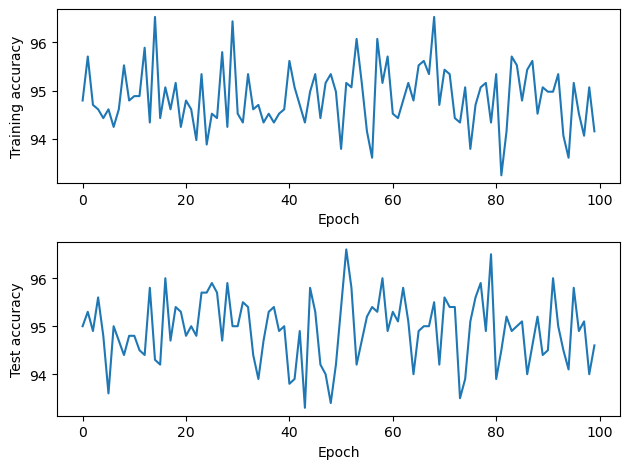

In [48]:
# fig = plt.figure(tight_layout=True)
# gs = gridspec.GridSpec(nrows=2, ncols=1)

# ax = fig.add_subplot(gs[0, 0])
# ax.plot(train_accuracies)
# ax.set_xlabel("Epoch")
# ax.set_ylabel("Training accuracy")

# ax = fig.add_subplot(gs[1, 0])
# ax.plot(test_accuracies)
# ax.set_xlabel("Epoch")
# ax.set_ylabel("Test accuracy")

# fig.align_labels()
# plt.show()

In [49]:
# # Predicting outputs using Neural net
# Predict_data = Feature_Transform(dftest)
# TorchP = torch.tensor(Predict_data.values, dtype=torch.float32)
# TorchP = TorchP.to(device)
# market = torch.argmax(model(TorchP), axis=1)
# market_output = market.detach().cpu().numpy()
# #The model has overfit and failed to predict

In [ ]:
# # Measuring importance using Random Forest 
# model = RandomForestClassifier()
# model.fit(Final_data,Y)
# #print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=Final_data.columns)
# feat_importances.nlargest(20).plot(kind='barh')
# plt.show()

In [ ]:
# #Measuring importance using xgboost
# import xgboost as xgb
# matrix = xgb.DMatrix(check,Y)
# # Create the parameter dictionary: params
# params = {"objective":"reg:linear","max_depth":"10"}
# # Train the model: xg_reg
# xg_reg = xgb.train(dtrain=dmatrix,params=params,num_boost_round=10)
# # Plot the feature importances
# xgb.plot_importance(xg_reg,max_num_features=20)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20, random_state=0)